In [1]:
import pandas as pd
import numpy as np
import random

import cv2
import glob
from PIL import Image

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

Using TensorFlow backend.


In [2]:
# function to read images from path. results are images
def read_images(path):
    return [Image.open(file) for file in glob.glob(path)]

In [3]:
path_y = './brain-mri-images-for-brain-tumor-detection/yes/*'
path_n = './brain-mri-images-for-brain-tumor-detection/no/*'

images_y = read_images(path_y)
images_n = read_images(path_n)
print(len(images_y))
print(len(images_n))

155
98


In [4]:
def show_images(img1, img2):
    plt.subplot(1,2,1)
    plt.imshow(img1)
    plt.title('Brain with tumor')
    plt.subplot(1,2,2)
    plt.imshow(img2)
    plt.title('Brain without tumor')

In [5]:
# show random image
def show_random_images(list1, list2):
    plt.subplot(1,2,1)
    plt.imshow(random.choice(list1))
    plt.title('Brain with tumor')
    plt.subplot(1,2,2)
    plt.imshow(random.choice(list2))
    plt.title('Brain without tumor')

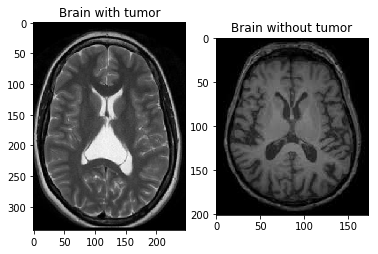

In [6]:
show_random_images(images_y, images_n)

In [7]:
# squaring images function:
# desired_size: a square which side is the max between original base and height
# creates a black image with desired size
# pastes the original image in the 'center' of the new image
def square_image(list_of_images):
    res = []
    for img in list_of_images:
        desired_size = (max(img.size), max(img.size))
        position = int(max(img.size)/2) - int(min(img.size)/2) 
        sq_img = Image.new("RGB", desired_size, color='black')
        if img.size[0] < img.size[1]:
            sq_img.paste(img, (0, position))
        else:
            sq_img.paste(img, (position, 0))
        res.append(sq_img)
    return res

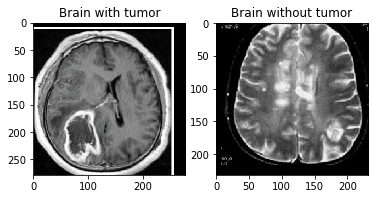

In [8]:
images_y_sq = square_image(images_y)
images_n_sq = square_image(images_n)
show_random_images(images_y_sq, images_n_sq)

In [9]:
# now we want to reshape all the images to 128x128
def resize_images(list_of_images, size=128):
    return [img.resize((size,size)) for img in list_of_images]

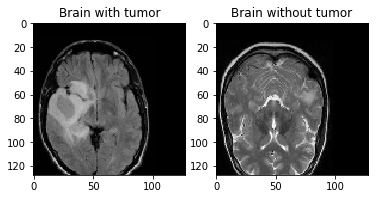

In [10]:
images_y_sq_rs = resize_images(images_y_sq)
images_n_sq_rs = resize_images(images_n_sq)
show_random_images(images_y_sq_rs, images_n_sq_rs)

In [11]:
# now we start to use open cv library, that works with numpy arrays instead of images
def image_to_nparray(list_of_images):
    return [np.array(img) for img in list_of_images]

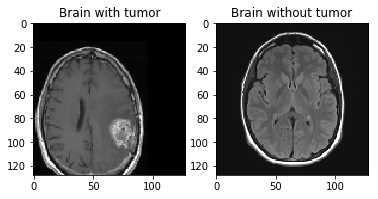

In [12]:
images_y_sq_rs_np = image_to_nparray(images_y_sq_rs)
images_n_sq_rs_np = image_to_nparray(images_n_sq_rs)
show_random_images(images_y_sq_rs_np, images_n_sq_rs_np)

In [13]:
# function to get gray scale images
def img_to_gray_scale(list_of_images):
    return [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in list_of_images]

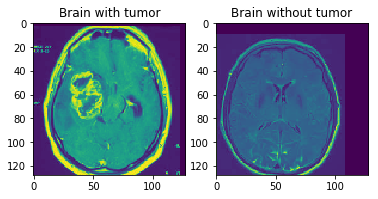

In [14]:
images_y_sq_rs_np_gs = img_to_gray_scale(images_y_sq_rs_np)
images_n_sq_rs_np_gs = img_to_gray_scale(images_n_sq_rs_np)
show_random_images(images_y_sq_rs_np_gs, images_n_sq_rs_np_gs)

In [15]:
# convert all images from gray to color
# def gray2bgr(list_of_images):
#     return [cv2.cvtColor(img, cv2.COLOR_GRAY2BGR) for img in list_of_images]

In [16]:
# images_y_sq_rs_np_bgr = gray2bgr(images_y_sq_rs_np)
# images_n_sq_rs_np_bgr = gray2bgr(images_n_sq_rs_np)
# show_random_images(images_y_sq_rs_np_bgr, images_n_sq_rs_np_bgr)

In [17]:
# skull removal
'''
def skull_removal(pic):
    gray = cv2.cvtColor(pic,cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_OTSU)
    ret, markers = cv2.connectedComponents(thresh)
    #Get the area taken by each component. Ignore label 0 since this is the background.
    marker_area = [np.sum(markers==m) for m in range(np.max(markers)) if m!=0]
    
    #Get label of largest component by area
    largest_component = np.argmax(marker_area)+1 #Add 1 since we dropped zero above                        

    #Get pixels which correspond to the brain
    brain_mask = markers==largest_component
    brain_out = pic.copy()
    #In a copy of the original image, clear those pixels that don't correspond to the brain
    brain_out[brain_mask==False] = (0,0,0)
    brain_mask = np.uint8(brain_mask)
    kernel = np.ones((8,8),np.uint8)
    closing = cv2.morphologyEx(brain_mask, cv2.MORPH_CLOSE, kernel)

    brain_out = pic.copy()
    #In a copy of the original image, clear those pixels that don't correspond to the brain
    brain_out[closing==False] = (0,0,0)
    return brain_out
'''

"\ndef skull_removal(pic):\n    gray = cv2.cvtColor(pic,cv2.COLOR_BGR2GRAY)\n    ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_OTSU)\n    ret, markers = cv2.connectedComponents(thresh)\n    #Get the area taken by each component. Ignore label 0 since this is the background.\n    marker_area = [np.sum(markers==m) for m in range(np.max(markers)) if m!=0]\n    \n    #Get label of largest component by area\n    largest_component = np.argmax(marker_area)+1 #Add 1 since we dropped zero above                        \n\n    #Get pixels which correspond to the brain\n    brain_mask = markers==largest_component\n    brain_out = pic.copy()\n    #In a copy of the original image, clear those pixels that don't correspond to the brain\n    brain_out[brain_mask==False] = (0,0,0)\n    brain_mask = np.uint8(brain_mask)\n    kernel = np.ones((8,8),np.uint8)\n    closing = cv2.morphologyEx(brain_mask, cv2.MORPH_CLOSE, kernel)\n\n    brain_out = pic.copy()\n    #In a copy of the original image, clear th

In [18]:
# def skull_removal_list(list_of_images):
#     return [skull_removal(img) for img in list_of_images]

In [19]:
'''
images_y_sq_rs_np_bgr_sr = skull_removal_list(images_y_sq_rs_np_bgr)
images_n_sq_rs_np_bgr_sr = skull_removal_list(images_n_sq_rs_np_bgr)
show_random_images(images_y_sq_rs_np_bgr_sr, images_n_sq_rs_np_bgr_sr)
'''

'\nimages_y_sq_rs_np_bgr_sr = skull_removal_list(images_y_sq_rs_np_bgr)\nimages_n_sq_rs_np_bgr_sr = skull_removal_list(images_n_sq_rs_np_bgr)\nshow_random_images(images_y_sq_rs_np_bgr_sr, images_n_sq_rs_np_bgr_sr)\n'

In [20]:
# function to apply a filter to soften the images
def median_filter(list_of_images):
    return [cv2.medianBlur(img,1) for img in list_of_images]

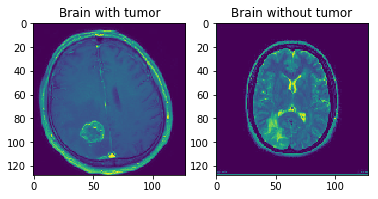

In [21]:
images_y_sq_rs_np_gs_mf = median_filter(images_y_sq_rs_np_gs)
images_n_sq_rs_np_gs_mf = median_filter(images_n_sq_rs_np_gs)
show_random_images(images_y_sq_rs_np_gs_mf, images_n_sq_rs_np_gs_mf)

In [22]:
# function to transform list of images to b&w
# I get the element 1 because it returs a tuple (threshold, image)
# meaning of the threshold: 0 is black, 255 is white, so I set that the pixels which are below 127
# turn black, and the ones that are above 127 turn white
# def images_to_bw(list_of_images):
#     return [cv2.threshold(img, 150, 255, cv2.THRESH_BINARY)[1] for img in list_of_images]

In [23]:
# images_y_sq_rs_np_bgr_sr_gs_mf_bw = images_to_bw(images_y_sq_rs_np_bgr_sr_gs_mf)
# images_n_sq_rs_np_bgr_sr_gs_mf_bw = images_to_bw(images_n_sq_rs_np_bgr_sr_gs_mf)
# show_random_images(images_y_sq_rs_np_bgr_sr_gs_mf_bw, images_n_sq_rs_np_bgr_sr_gs_mf_bw)

In [24]:
# function to convert the images (np arrays 256x256) in 1d arrays
# and then put them all together in a pandas dataframe
def list_np_to_pd(list_of_images):
    return pd.DataFrame([img.flatten() for img in list_of_images])

In [25]:
# execution of the function
images_dataframe_y = list_np_to_pd(images_y_sq_rs_np_gs_mf)
images_dataframe_n = list_np_to_pd(images_n_sq_rs_np_gs_mf)

In [26]:
print(images_dataframe_y.shape)
print(images_dataframe_n.shape)

(155, 16384)
(98, 16384)


In [27]:
# input image dimensions
img_rows, img_cols = 128, 128

df_y = images_dataframe_y.T
df_n = images_dataframe_n.T

num_y = df_y.values.shape[1]
num_n = df_n.values.shape[1]
print("y:{} n:{}".format(num_y, num_n))

yes = df_y.values.reshape((img_rows, img_cols, num_y))
no = df_n.values.reshape((img_rows, img_cols, num_n))
X = np.concatenate((yes,no), axis=2).swapaxes(2,0)
y = np.concatenate((np.ones(num_y), np.zeros(num_n)))
print("Shapes X={} y={}".format(X.shape,y.shape))

y:155 n:98
Shapes X=(253, 128, 128) y=(253,)


In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [29]:
# Prepare data to feed the NN
num_classes = 2

# Ask keras which format to use depending on used backend and arrange data as expected
if K.image_data_format() == 'channels_first':
    X_train = x_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = x_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

# Incoming data is in uint8. Cast the input data images to be floats in range [0.0-1.0]  
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

print('x_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


x_train shape: (227, 128, 128, 1)
227 train samples
26 test samples


In [30]:
## This is the neural network proposed architecture
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [31]:
# Fit the NN
batch_size = 20
epochs = 1

model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, y_test))

Instructions for updating:
Use tf.cast instead.
Train on 227 samples, validate on 26 samples
Epoch 1/1
227/227 [==============================] - 16s 72ms/step - loss: 1.7194 - acc: 0.6167 - val_loss: 0.4513 - val_acc: 0.8846


In [32]:
# Evaluate the model with test data
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.45128685235977173
Test accuracy: 0.8846153616905212


In [33]:
print(type(X_test))

<class 'numpy.ndarray'>


Probs -> 1:0.63743 0:0.36257


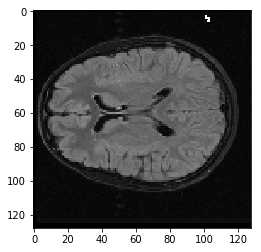

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
img = X_test[3]
pred = model.predict(np.expand_dims(img,axis=0))[0]
print("Probs -> 1:{0:.5f} 0:{1:.5f}".format(pred[0],pred[1]))
plt.imshow(Image.fromarray(img.squeeze()*255),'gray')

In [35]:
y_pred = [int(round(model.predict(np.expand_dims(e,axis=0))[0][0])) for e in X_test]
print(y_pred)

[1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [36]:
y_true = [int(e[0]) for e in y_test]
print(y_true)

[1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0]


In [37]:
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[14  1]
 [ 2  9]]


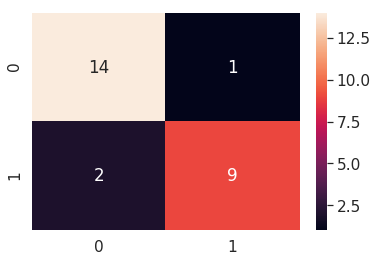

In [44]:
sns.heatmap(cm, annot=True)